# HRD Feature Engineering | HRD Score with Genomic Scar-Based Metrics

**Objective**: Construct biologically-grounded genomic scar-based HRD scores from DepMap cell line data to support downstream analyses of PARP inhibitor sensitivity across relevant cancer models.

---
---
---

## 1. Setup 📦

---
---

In [1]:
# Data Management
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import ptitprince as pt
import seaborn as sns

# Computational Modules
from scipy.stats import norm, spearmanr, zscore
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler, StandardScaler

# Utils
from IPython.display import display, HTML, IFrame, Image
from pathlib import Path

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid', {'grid.color':'0.9','xtick.bottom':True,'ytick.left':True})

## 2. Data Loading ⚙️

**Objective**: Load and organize the curated cell line cohort, DepMap mutation data, and any external HRD-related feature sets needed for this notebook.

---
---

In [2]:
# Define project root and file path relative to user OS
BASE_DIR = Path.cwd()
BRCA_DF_PATH                = BASE_DIR / 'utils' / 'brca_df.pkl'
OMICS_SIGNATURES_PATH       = BASE_DIR / 'data' / 'OmicsGlobalSignatures.csv'

In [3]:
# Load data into local dataframe (with disabled chunked dtype inference)
brca_df                     = pd.read_pickle(BRCA_DF_PATH)
omics_signatures_df         = pd.read_csv(OMICS_SIGNATURES_PATH, low_memory=False)

The original datasets were downloaded from DepMap’s public [portal](https://depmap.org/portal/data_page/?tab=allData).

- **`omics_signatures_df`**: Contains genome-wide instability metrics derived from WES/WGS data, including loss of heterozygosity fraction (LoHFraction), chromosomal instability (CIN), whole-genome doubling (WGD), and aneuploidy scores. These features serve as continuous proxies for HRD–associated genomic scarring.

This project aims to systematically examine how multiple definitions of HRD relate to drug response across all PARP inhibitors available in the dataset. So each of the HRD feature engineering notebooks will derive homologous recombination deficiency (HRD) status using one of three complementary strategies: (1) BRCA1/2 double-hit alteration status, (2) computed genomic scar–based HRD scores, and (3) COSMIC mutational signatures. These engineered features will then be harmonized with PARP inhibitor AUC measurements to generate a modeling-ready dataset for downstream statistical analysis and predictive modeling of HRD-associated drug response. This notebook will focus on deriving an HRD score using genomic scar-based metrics, while the next notebook leverages external sources to compute a canonical score for available cell line data. 

## 3. Proxy HRD Score [HRD Component 2 | Version 1] 🧮

**Objective**: Leverage genomic scar metrics available in DepMap (LOH, CIN, WGD, and Aneuploidy) to create a proxy HRD score.

---
---

Not all HRD is driven by BRCA1/2 mutations. Defects in other components of the homologous recombination pathway can similarly compromise DNA repair, leading to characteristic patterns of chromosomal instability (i.e., **genomic scars**). Although canonical genomic scar scores are not available via DepMap, related metrics such as **loss of heterozygosity** (**LOH**), **chromosomal instability** (**CIN**), **whole-genome doubling** (**WGD**), and **aneuploidy** capture these patterns. These features were already extracted from the Omics Global Signatures dataset, and therefore will serve as proxies to detect HRD in BRCA wild-type cell lines.

In this section, these metrics will be integrated into a composite score to define a binary HRD label (`proxy_HRD_status`), in order to identify cell lines that lack BRCA mutations but still exhibit HRD-like genomic instability patterns.


### 3a. Extract genomic scar metrics and perform basic validation checks.

---

In [4]:
# Subset relevant genomic scar metrics
scar_metrics = ['LoHFraction', 'CIN', 'WGD', 'Aneuploidy']
genomic_scar_df = omics_signatures_df[['ModelID'] + scar_metrics].copy()

genomic_scar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ModelID      3021 non-null   object 
 1   LoHFraction  2582 non-null   float64
 2   CIN          2582 non-null   float64
 3   WGD          2582 non-null   float64
 4   Aneuploidy   2582 non-null   float64
dtypes: float64(4), object(1)
memory usage: 118.1+ KB


The four relevant scar metrics were extracted above for each cell line. However, only 2582 of the 3021 models contained complete information. The remaining missing records must be addressed before standardizing these features to create a composite HRD score. Following the framework outlined by *[Little & Rubin (1987)](https://stefvanbuuren.name/fimd/sec-MCAR.html)*, the mechanism of missingness was assessed. Since the same cell line models are missing values across all four metrics, the data is most consistent with a *Missing at Random (MAR)* scenario due to assay availability. Therefore, imputation is required to mitigate any potential bias.

A deeper look into the distributions of these features will be useful to determine the proper steps for imputing missing data and creating a composite score. 

In [5]:
# Check for any duplicate ccl records
genomic_scar_df_dups = genomic_scar_df[genomic_scar_df.duplicated(subset='ModelID', keep=False)].sort_values(by='ModelID')

# Verify any contradictory genomic scar metrics
genomic_scar_df_dups_contradictory = (
    genomic_scar_df_dups
    .groupby('ModelID')
    .filter(lambda x: (x[['LoHFraction', 'CIN', 'WGD', 'Aneuploidy']].nunique() > 1).any())
)

genomic_scar_df_dups_contradictory

,ModelID,LoHFraction,CIN,WGD,Aneuploidy
34,ACH-000001,0.173789,0.649594,1.0,23.0
1515,ACH-000001,0.246913,0.524343,1.0,17.0
1357,ACH-000004,0.347968,0.486037,1.0,20.0
609,ACH-000004,0.349629,0.484525,1.0,20.0
22,ACH-000005,0.339925,0.484917,1.0,20.0
...,...,...,...,...,...
1520,ACH-002511,0.076783,0.605210,1.0,24.0
33,ACH-002800,0.324559,0.711778,1.0,24.0
502,ACH-002800,0.363531,0.704515,1.0,25.0
933,ACH-003071,0.452423,0.704602,1.0,23.0


Basic data validation of the genomic scar data revealed several cell lines (`ModelID`) appearing multiple times with slightly differing measurements across `LoHFraction`, `CIN`, `WGD`, and `Aneuploidy`. These duplicate entries likely occur [because](https://depmap.sanger.ac.uk/documentation/frequently-asked-questions/?utm_source=chatgpt.com) from multiple sequencing runs, experimental replicates, or parallel profiling efforts for the same cell line in DepMap, leading to slightly differing measurements for the same `ModelID`.

To generate a single representative row per cell line, a gene/metric-specific aggregation strategy will be applied. Continuous metrics such as `LoHFraction`, `CIN`, and `Aneuploidy` are summarized using the mean across replicates to capture the central tendency while smoothing minor experimental variability. Binary or categorical metrics like `WGD` are aggregated using the maximum value to ensure that any occurrence of a whole-genome duplication is preserved. This approach reconciles duplicate entries without losing biologically relevant events and ensures one consolidated row per cell line for downstream HRD and genomic analyses.

In [6]:
# Aggregate genomic scar metrics by ModelID
genomic_scar_df = genomic_scar_df.groupby('ModelID').agg({
            'LoHFraction': 'mean',    # average across replicates
            'CIN': 'mean',            # average across replicates
            'WGD': 'max',             # flag if any replicate shows WGD
            'Aneuploidy': 'mean'      # average across replicates
        }).reset_index()

# Inspect to verify no more duplicates
genomic_scar_df[genomic_scar_df.duplicated(subset='ModelID', keep=False)]

,ModelID,LoHFraction,CIN,WGD,Aneuploidy


### 3b. Explore each metric and execute any necessary preprocessing steps.

---

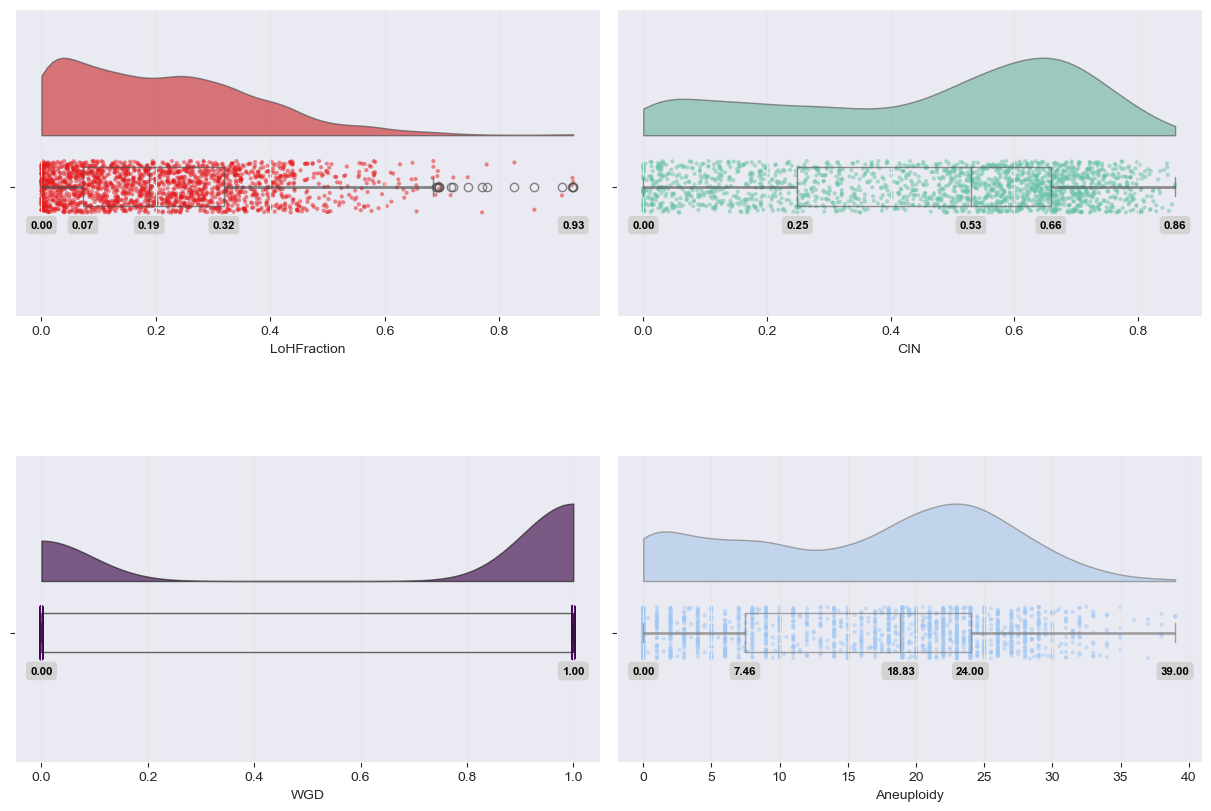

In [7]:
# Set up figure & individual subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), 
    layout='constrained', gridspec_kw={'hspace': 0.25})
axs = axs.flatten()  # for easy indexing
rc_palettes = ['Set1', 'Set2', 'viridis', 'pastel']

# Plot raincloud for each metric
for i, metric in enumerate(scar_metrics):
    cloud = pt.RainCloud(
        data=genomic_scar_df,
        y=metric,
        bw=0.2,
        alpha=0.65,
        rain_alpha=0.5,
        width_viol=0.6,
        orient='h',
        palette=rc_palettes[i],
        hue=i,
        ax=axs[i],
    )
    
    # Label quartiles
    desc_stats = genomic_scar_df[[metric]].quantile(q=[0, 0.25, 0.5, 0.75, 1])
    for stat in desc_stats[metric]:
        cloud.text(
            s=f"{stat:.2f}",
            x=stat,
            y=0.16,
            ha='center',
            size='small',
            color='black',
            weight='semibold',
            bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
        )

**Observations:**

`LoHFraction`

- Right-skewed distribution with most observations concentrated at low values 
- Small sample of outliers with high loss of heterozygosity (up to ~0.93)
- Median: 0.19, IQR: 0.07 - 0.32

`CIN`

- Broadly distributed with an overall left skew (peak near the 75th percentile)
- Values mostly concentrated in two areas: above the median and below the 25th percentile
- More variability compared to LoHFraction, but fewer extreme outliers indicating substantial chromosomal instability across many samples, rather than being confined to a small subset
- Median: 0.53, IQR: 0.25 - 0.66

`WGD`

- Binary (0 or 1) distribution, representing the presense / absence of whole-genome duplication
- Most samples show WGD, with only a smaller subset at the 0 mark (Median: 1)

`Aneuploidy`

- Discrete, integer-valued distribution reflecting whole chromosome or chromosome-arm alterations
- Broadly distributed with an asymmetric shape, peaking between the median and 75th percentile
- Declines sharply toward higher values, with a broader shoulder toward lower aneuploidy 
- Median: 18.83, IQR: 7.46 - 24.00

Overall, these genomic instability metrics exhibit markedly different distributions. Loss of heterozygosity is generally low, with rare extreme values, while CIN and Aneuploidy show broader, more continuous variation across samples. These patterns suggest that genomic instability arises through multiple, partially independent mechanisms, with different samples showing distinct dominant instability patterns.

Given these distributional characteristics, missing data should be imputed using the median to mitigate the influence of skew and outliers. Additionally, when combining these metrics into a composite score, standardization (via scaling techniques) is essential to account for their differing distributions and ranges.

In [8]:
# Impute missing values with median for each scar metric
genomic_scar_df[scar_metrics] = genomic_scar_df[scar_metrics].fillna(
    genomic_scar_df[scar_metrics].median())

### 3c. Scale each metric to prepare for integration into singular feature.

---

In [9]:
# Fit and transform the four scar metrics
scaler = StandardScaler()
scaled_values = scaler.fit_transform(genomic_scar_df[scar_metrics].copy())

# Create new scaled columns
scaled_col_names = [f'z_{col}' for col in scar_metrics]
scaled_genomic_scar_df = genomic_scar_df.copy()
scaled_genomic_scar_df[scaled_col_names] = scaled_values

scaled_genomic_scar_df.head()

,ModelID,LoHFraction,CIN,WGD,Aneuploidy,z_LoHFraction,z_CIN,z_WGD,z_Aneuploidy
0,ACH-000001,0.210351,0.586968,1.0,20.0,0.000817,0.524007,0.679070,0.376577
1,ACH-000002,0.073472,0.114264,0.0,6.0,-0.866280,-1.496511,-1.472602,-1.111930
2,ACH-000004,0.348798,0.485281,1.0,20.0,0.877844,0.089357,0.679070,0.376577
3,ACH-000005,0.351651,0.494317,1.0,20.0,0.895914,0.127979,0.679070,0.376577
4,ACH-000006,0.081062,0.190795,0.0,8.0,-0.818203,-1.169389,-1.472602,-0.899286


The genomic scar metrics span different numerical ranges and distributional shapes, so they must be placed on a common scale before being combined into a composite metric. Each feature was therefore standardized using z-score normalization, allowing values to represent how extreme a cell line is relative to the overall population. This approach prevents any single metric from dominating the composite score solely due of its magnitude, while still preserving biologically meaningful variation across samples.

Alternative approaches, such as robust scaling, were considered here due to the presence of extreme outliers in some metrics. However, because the primary goal is to capture relative deviation from the cohort mean rather than attentuate extremes, z-scoring was deemed more appropriate. Although robust scalers reduce the influence of outliers and are useful for noise control, the high values observed here likely represent true biological signals associated with HRD. Moreover, the large sample size, combined with prior median-based imputation, further mitigates outlier influence already, further strengthening the case for a standard scalar. 

Standardization centers each genomic scar metric at the cohort mean and expresses values in units of standard deviation. Under this transformation, a value of zero represents the average level of genomic instability, positive values indicate above-average scar burden, and negative values indicate below-average burden.

This transformation enables direct comparison and aggregation across variables that originally differed in scale, range, and distribution. For the binary WGD column, z-score normalization simply maps absence to below-average instability and presence to above-average instability, preserving its biological interpretation while allowing it to contribute proportionally to the composite score.

With all four genomic scar metrics placed on a common scale, they can now be integrated into a single composite feature representing genomic scar–based HRD.

### 3d. Integrate genomic scar metrics into singular scar-based HRD score.

---

In [10]:
# Compute composite HRD score using mean of the scaled data
scaled_genomic_scar_df['proxy_HRD_genomic_score'] = scaled_genomic_scar_df[scaled_col_names].mean(axis=1)

scaled_genomic_scar_df[['ModelID', 'proxy_HRD_genomic_score']].head()

,ModelID,proxy_HRD_genomic_score
0,ACH-000001,0.395118
1,ACH-000002,-1.236831
2,ACH-000004,0.505712
3,ACH-000005,0.519885
4,ACH-000006,-1.089870


The standardized genomic scar metrics were averaged to generate a continuous composite HRD score. Because each feature is expressed in units of standard deviation, this approach ensures equal contribution from all metrics without allowing any single feature to dominate due to scale differences. Higher values correspond to greater overall genomic instability consistent with homologous recombination deficiency.

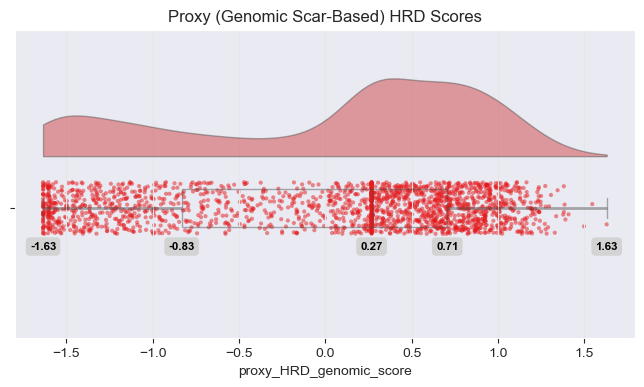

In [11]:
# Set up figure for composite score
plt.figure(figsize=(8, 4))

# Plot raincloud for composite metric
composite_cloud = pt.RainCloud(
    data=scaled_genomic_scar_df,
    y='proxy_HRD_genomic_score',
    bw=0.2,
    alpha=0.45,
    rain_alpha=0.5,
    width_viol=0.6,
    orient='h',
    palette='Set1',
    hue=0,
)

# Label quartiles
composite_desc_stats = scaled_genomic_scar_df[['proxy_HRD_genomic_score']].quantile(q=[0, 0.25, 0.5, 0.75, 1])
for stat in composite_desc_stats['proxy_HRD_genomic_score']:
    composite_cloud.text(
        s=f"{stat:.2f}",
        x=stat,
        y=0.16,
        ha='center',
        size='small',
        color='black',
        weight='semibold',
        bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
    )

plt.title('Proxy (Genomic Scar-Based) HRD Scores')
plt.show()

The feature-engineered composite genomic HRD score ranges from −1.63 to 1.63, demonstrating substantial variability across cell lines. The distribution is fairly unimodal and centered slightly above the median (0.27), with most models occupied densely above that range. Negative scores indicate genomic instability levels below the cohort mean, while positive scores reflect above-average burden relative to other models. No extreme or isolated artifacts are evident, suggesting the aggregation and scaling steps produced a stable continuous measure suitable for downstream threshold-based classification. The next step involves figuring out this exact threshold.

### 3e. Derive threshold for converting proxy genomic scar scores into HRD+ status. 

---

In [12]:
# Fit 2-Component GMM on HRD scores
hrd_genomic_scores = scaled_genomic_scar_df['proxy_HRD_genomic_score'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(hrd_genomic_scores)

# Get means and covariances of the two Gaussians
gmm_means = gmm.means_.flatten()
gmm_covs = gmm.covariances_.flatten()
mu1, mu2 = gmm_means
sigma1, sigma2 = np.sqrt(gmm_covs)

In [13]:
### Compute the intersection point of the two Gaussians (Solve: N1(x) = N2(x) for x)

# Quadratic coefficients for solving intersection
a = 1/(2*sigma1**2) - 1/(2*sigma2**2)
b = mu2/(sigma2**2) - mu1/(sigma1**2)
c = (mu1**2)/(2*sigma1**2) - (mu2**2)/(2*sigma2**2) - np.log(sigma2/sigma1)

# Solve for x (intersection point)
threshold_candidates = np.roots([a, b, c])

# Pick the value within the range of observed scores
threshold = threshold_candidates[(threshold_candidates > hrd_genomic_scores.min()) & (threshold_candidates < hrd_genomic_scores.max())][0]
print(f'GMM-derived HRD threshold: {threshold:.3f}')

# Create binary HRD label
scaled_genomic_scar_df['proxy_HRD_status'] = (scaled_genomic_scar_df['proxy_HRD_genomic_score'] >= threshold).astype(int)

GMM-derived HRD threshold: -0.312


In [14]:
# Validate the engineered threshold by checking overlap with BRCA-positive cell lines
brca_overlap = brca_df.merge(
    scaled_genomic_scar_df[['ModelID', 'proxy_HRD_genomic_score']], on='ModelID'
)
brca_positive_rate = brca_overlap[brca_overlap['BRCA_HRD'] == 1]['proxy_HRD_genomic_score'].mean()
print(f'Fraction of BRCA-mutant lines captured as HRD-positive: {brca_positive_rate:.2%}')

Fraction of BRCA-mutant lines captured as HRD-positive: 32.28%


To convert the continuous composite genomic HRD score into a binary label, a two-component Gaussian Mixture Model (GMM) was fitted to the score distribution. This approach assumes that cell lines comprise two overlapping subpopulations corresponding to HRD-negative (lower genomic instability) and HRD-positive (higher genomic instability) states.

The intersection point of the two Gaussian components was computed analytically and used as the classification threshold, providing an objective, data-driven cutoff rather than relying on an arbitrary percentile-based rule. Using this approach, a threshold of −0.312 was identified and applied to define the binary genomic scar–based HRD label. This threshold lies within the dense region of the score distribution and does not rely on extreme values, indicating a stable and robust separation between subpopulations.

To assess biological validity, the resulting classification was compared against BRCA1/2 mutation status. The majority of BRCA-mutant cell lines were classified as HRD-positive under this threshold, confirming that the genomic scar–based definition captures canonical HRD cases while also identifying BRCA wild-type models with HRD-like genomic instability. Together, these results support both the statistical validity and biological relevance of the engineered HRD label.

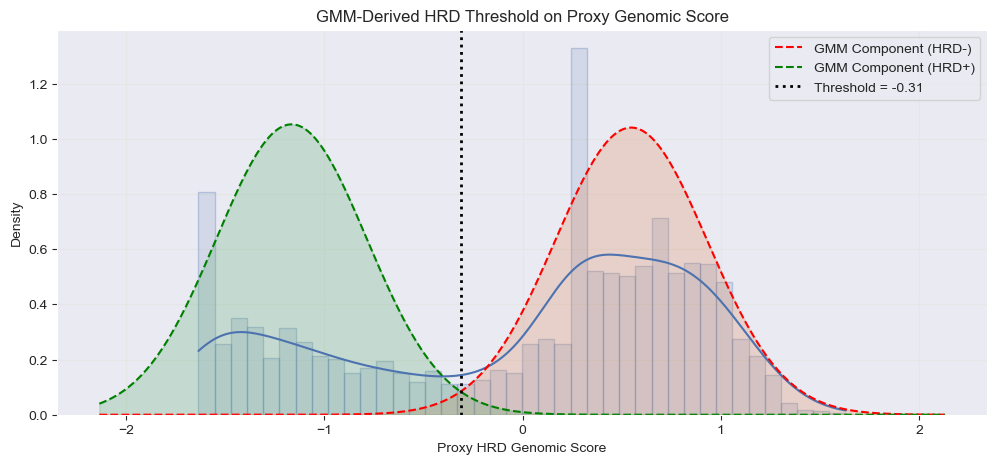

In [15]:
# Set up figure
plt.figure(figsize=(12, 5))

# Plot the histogram + KDE of HRD scores
sns.histplot(
    scaled_genomic_scar_df['proxy_HRD_genomic_score'], 
    bins=40, 
    kde=True, 
    color='#4C72B0', 
    stat='density', 
    alpha=0.15, 
    edgecolor=(0.298, 0.447, 0.69, 0.30)  # in RGB format to accomodate edge alpha
)

# Plot the two GMM components 
x_vals = np.linspace(hrd_genomic_scores.min()-0.5, hrd_genomic_scores.max()+0.5, 1000)
pdf1 = norm.pdf(x_vals, loc=mu1, scale=sigma1)
pdf2 = norm.pdf(x_vals, loc=mu2, scale=sigma2)
plt.plot(x_vals, pdf1, color='red', linestyle='--', label='GMM Component (HRD-)')
plt.plot(x_vals, pdf2, color='green', linestyle='--', label='GMM Component (HRD+)')
plt.fill_between(x_vals, pdf1, color='#DD8452', alpha=0.25)
plt.fill_between(x_vals, pdf2, color='#55A868', alpha=0.25)

# Plot the threshold
plt.axvline(threshold, color='black', linestyle='dotted', linewidth=2, label=f'Threshold = {threshold:.2f}')

# Output labels and legend
plt.title('GMM-Derived HRD Threshold on Proxy Genomic Score')
plt.xlabel('Proxy HRD Genomic Score')
plt.ylabel('Density')
plt.legend()
plt.show()

The histogram and KDE (in blue) show the distribution of composite genomic HRD scores across cell lines. The red and green dashed lines correspond to the two Gaussian components fitted by the GMM, representing the inferred HRD-negative and HRD-positive subpopulations. The black dotted line indicates the analytically derived threshold used to convert the continuous HRD score into the binary `proxy_HRD_status` label.

This visualization demonstrates how the data-driven threshold effectively separates cell lines with low versus high genomic instability while reflecting the natural structure of the score distribution. It also provides a visual validation that the threshold is reasonable and aligns with the density of the observed scores.

In [16]:
scaled_genomic_scar_df.proxy_HRD_status.value_counts()

proxy_HRD_status
1    1316
0     639
Name: count, dtype: int64

Based on the above examination, the proxy score determining process seemed to aggresively label cell lines as HRD based on the GMM-based thresholds. Another iteration of this process with modified approach might be needed to produce more realistic scores and a more reliably HRD status label.

## 4. Summary & Export 💾 

---
---

In [17]:
# Export merged data as reusable pickle file for HRD feature engineering
scaled_genomic_scar_df.to_pickle(BASE_DIR / 'utils' / 'proxy_hrd.pkl')

scaled_genomic_scar_df

,ModelID,LoHFraction,CIN,WGD,Aneuploidy,z_LoHFraction,z_CIN,z_WGD,z_Aneuploidy,proxy_HRD_genomic_score,proxy_HRD_status
0,ACH-000001,0.210351,0.586968,1.0,20.0,0.000817,0.524007,0.679070,0.376577,0.395118,1
1,ACH-000002,0.073472,0.114264,0.0,6.0,-0.866280,-1.496511,-1.472602,-1.111930,-1.236831,0
2,ACH-000004,0.348798,0.485281,1.0,20.0,0.877844,0.089357,0.679070,0.376577,0.505712,1
3,ACH-000005,0.351651,0.494317,1.0,20.0,0.895914,0.127979,0.679070,0.376577,0.519885,1
4,ACH-000006,0.081062,0.190795,0.0,8.0,-0.818203,-1.169389,-1.472602,-0.899286,-1.089870,0
...,...,...,...,...,...,...,...,...,...,...,...
1950,ACH-003473,0.073994,0.122432,0.0,6.0,-0.862974,-1.461596,-1.472602,-1.111930,-1.227276,0
1951,ACH-003474,0.223545,0.632398,1.0,18.0,0.084397,0.718192,0.679070,0.163933,0.411398,1
1952,ACH-003475,0.076641,0.474687,1.0,22.0,-0.846207,0.044073,0.679070,0.589221,0.116539,1
1953,ACH-003476,0.079809,0.512550,1.0,24.0,-0.826139,0.205914,0.679070,0.801865,0.215177,1


This notebook defines **genomic-scar based HRD scores** as the second component (v1) of HRD profiling that will be used in this project.

A genomic scar score extends HRD detection to the BRCA wild-type models from the previous notebook that exhibit patterns of genomic instability consistent with HRD despite no "double-hit" mutations. The use of a Gaussian mixture model to define the genomic HRD threshold leverages the empirical structure of the data, avoiding arbitrary cutoffs and enhancing reproducibility and interpretability.

Several considerations are important when using these features in downstream analyses. First, genomic scar metrics represent indirect surrogates of pathway activity and may reflect historical rather than current repair capacity. Second, the two-component mixture model simplifies HR competence into discrete states, whereas in reality, homologous recombination proficiency likely exists along a continuum. The resulting HRD classification is imbalanced, with a substantially larger fraction of models labeled positive than negative. This stems from the intentionally inclusive design of the genomic scar framework, which aims to capture potential HR dysfunction across diverse biological contexts. While suitable for discovery-oriented analyses, this skew must be considered in statistical comparisons and predictive modeling, as unequal group sizes can bias effect estimates, probability calibration, and performance metrics.

There are several opportunities for imporvement in future iterations. Rather than relying exclusively on hard class assignments, posterior probabilities from the mixture model could represent uncertainty in HRD membership, allowing borderline cases to contribute proportionally to statistical tests and predictive models. Sensitivity analyses exploring alternative component numbers, resampling strategies, or percentile-based thresholds could further evaluate the robustness of the chosen cutoff.

Despite these caveats, the resulting HRD labels are biologically grounded and well-suited for systematic evaluation against PARP inhibitor response. The next notebook will leverage external data from publicly-available resources to extract canonical HRD scores for as many cell lines as possible, knowing that the proxy scores are available as a backup.